In [93]:
import numpy as np
import pandas as pd

%matplotlib inline

In [6]:
data = pd.DataFrame(
    {'x': np.random.normal(loc=0, scale=1, size=10),
     'y': np.random.normal(loc=0, scale=3, size=10),
     'z': np.random.normal(loc=10, scale=0.5, size=10)}
)

In [117]:
rate=10
print(np.random.exponential(scale=1/rate, size=1)[0])

0.140203263565


In [127]:
def calculate_box(data): 
    return data.agg([min, max]).values.transpose()

def dimensions(box):
    return np.diff(box, axis=1).flatten()

def linear_dimension(box):
    return dimensions(box).sum()

def select_axis(dimensions, size=None):
    if size is None:
        size = len(dimensions)
    return np.random.choice(range(size), p=dimensions/np.sum(dimensions))

def select_cut_point(interval):
    return np.random.uniform(low=interval[0], high=interval[1], size=1)[0]

def time_to_next_cut(box):
    return np.random.exponential(scale=1.0/linear_dimension(box), size=1)[0]

def split_box(box, axis, point):
    left = box.copy()
    right = box.copy()
    low, high = box[axis]
    
    if point <= low or point >= high:
        raise ValueError('Point is not in interval.')
        
    left[axis] = [low, point]
    right[axis] = [point, high]
    return left, right

In [134]:
def mondrian_cut(time, box, time_bound):
    next_cut_time = time + time_to_next_cut(box)
    
    if next_cut_time >= time_bound:
        return (time, next_cut_time, box, None, None, None, None)
    
    cut_axis = select_axis(dimensions(box))
    cut_point = select_cut_point(box[cut_axis])
    left_box, right_box = split_box(box, cut_axis, cut_point)
    
    return (time, next_cut_time, box, cut_axis, cut_point, 
            mondrian_cut(next_cut_time, left_box, time_bound), 
            mondrian_cut(next_cut_time, right_box, time_bound))

In [251]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

def segments_2d(box):
    low_x, high_x = box[0]
    low_y, high_y = box[1]
    return [[(low_x, low_y), (high_x, low_y)], 
            [(high_x, low_y), (high_x, high_y)], 
            [(high_x, high_y), (low_x, high_y)],
            [(low_x, high_y), (low_x, low_y)]]

def segments(m, segs):
    segs.extend(segments_2d(m[2]))
    if m[5] is not None and m[6] is not None:
        segments(m[5], segs)
        segments(m[6], segs)

def plot_mondrian(m):
    segs = []
    segments(m, segs)
    lines = segs
    lc = mc.LineCollection(lines, colors='orangered', linewidths=1)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.05)

In [252]:
box = np.array([[0.0, 1.0], [0.0, 1.0]]) 

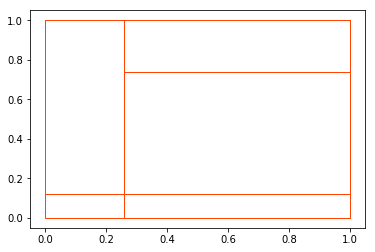

In [253]:
plot_mondrian(mondrian_cut(0, box, 1))

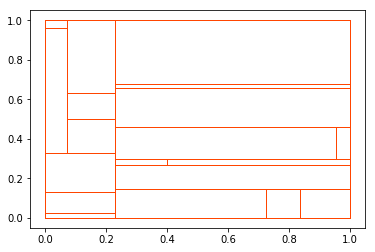

In [254]:
plot_mondrian(mondrian_cut(0, box, 2))

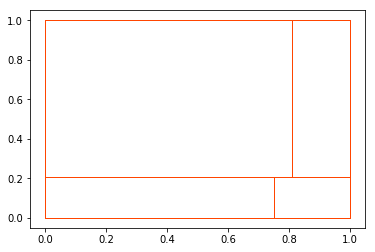

In [255]:
plot_mondrian(mondrian_cut(0, box, 3))

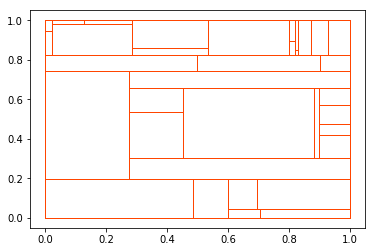

In [256]:
plot_mondrian(mondrian_cut(0, box, 4))

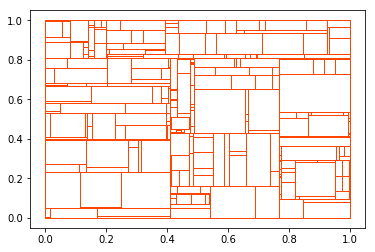

In [257]:
plot_mondrian(mondrian_cut(0, box, 20))

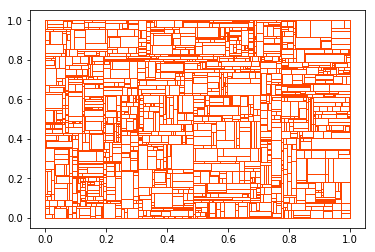

In [258]:
plot_mondrian(mondrian_cut(0, box, 50))